<a href="https://colab.research.google.com/github/sreent/dense-neural-networks/blob/main/codes/German%20Credit%20Data%20-%20SMOTE%20Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## Defining the problem and assembling a dataset

- German Credit Data
  - https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)
- Binary Classification Problem

 ## Choosing a measure of success

- Accuracy Score
- F1 Score

## Deciding on an evaluation protocol

- Maintaining a hold-out validation set
- Doing K-fold cross-validation

## Preparing your data

In [ ]:
import pandas as pd
import numpy as np

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

import itertools
import matplotlib.pyplot as plt

SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
FILE_PATH = 'http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'

HEADERS = ['Status of existing checking account', 'Duration in month', 'Credit history',
           'Purpose','Credit amount', 'Savings account/bonds', 'Present employment since',
           'Installment rate in percentage of disposable income', 'Personal status and sex',
           'Other debtors / guarantors', 'Present residence since', 'Property', 'Age in years',
           'Other installment plans', 'Housing', 'Number of existing credits at this bank',
           'Job', 'Number of people being liable to provide maintenance for', 'Telephone', 'Foreign worker',
           'Cost Matrix(Risk)']

In [ ]:
df = pd.read_csv(FILE_PATH, sep=" ", header=None)
df.columns = HEADERS

df.head()

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,Foreign worker,Cost Matrix(Risk)
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [ ]:
NUMERICAL_VARIABLES = ['Duration in month', 'Credit amount', 'Installment rate in percentage of disposable income',
                     'Present residence since', 'Age in years', 'Number of existing credits at this bank',
                     'Number of people being liable to provide maintenance for']

CATEGORICAL_VARIABLES = ['Status of existing checking account', 'Credit history',
                         'Purpose', 'Savings account/bonds', 'Present employment since',
                         'Personal status and sex', 'Other debtors / guarantors',
                         'Property', 'Other installment plans', 'Housing',
                         'Job', 'Telephone', 'Foreign worker']

In [ ]:
features = df[NUMERICAL_VARIABLES + CATEGORICAL_VARIABLES]

In [ ]:
TARGET_VARIABLE = 'Cost Matrix(Risk)'

target = df[TARGET_VARIABLE]

In [ ]:
TEST_SIZE = 0.1

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=TEST_SIZE,
                                                    random_state=SEED, shuffle=True, stratify=target.values)

In [ ]:
preprocessor = ColumnTransformer([
    ('one-hot-encoder', OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_VARIABLES),
    ('standard_scaler', StandardScaler(), NUMERICAL_VARIABLES)])

_ = preprocessor.fit(X_train)

In [ ]:
X_train, X_test = preprocessor.transform(X_train), preprocessor.transform(X_test)

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=VALIDATION_SIZE, stratify=y_train,
                                                  shuffle=True, random_state=SEED)

In [ ]:
sm = SMOTE(sampling_strategy='auto', random_state=SEED)
Xs, ys = sm.fit_resample(X_train, y_train)

In [ ]:
Xs_train, Xs_val, ys_train, ys_val = train_test_split(Xs, ys, test_size=VALIDATION_SIZE,
                                                      random_state=SEED, shuffle=True,
                                                      stratify=ys)

##  Developing a model that does better than a baseline

In [ ]:
counts = df.groupby([TARGET_VARIABLE])[TARGET_VARIABLE].count()
counts

Cost Matrix(Risk)
1    700
2    300
Name: Cost Matrix(Risk), dtype: int64

In [ ]:
df[TARGET_VARIABLE].unique()

array([1, 2])

In [ ]:
naive_baseline = len(df[df[TARGET_VARIABLE]==1]) / len(df)

naive_baseline

0.7

In [ ]:
INPUT_DIMENSION = Xs_train.shape[1]
OUTPUT_DIMENSION = 1

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy']

MONITOR = 'val_loss'
PATIENCE = 5

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=0)

In [ ]:
baseline = Sequential(
    [
        Dense(32, activation="relu", input_shape=(INPUT_DIMENSION,), name="hidden"),
        Dense(OUTPUT_DIMENSION, activation="sigmoid", name="output")
    ],
    name="baseline"
)

baseline.summary()

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 32)                1984      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 2017 (7.88 KB)
Trainable params: 2017 (7.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
learning_rate = 0.001
batch_size = 32

EPOCHS = 500

In [ ]:
baseline.compile(optimizer=RMSprop(learning_rate=learning_rate),
                 loss=LOSS_FUNC, metrics=METRICS)

In [ ]:
baseline_history = baseline.fit(Xs_train, ys_train,
                                batch_size=batch_size, epochs=EPOCHS,
                                validation_data=(Xs_val, ys_val),
                                callbacks=[EARLY_STOP],
                                verbose=0)

In [ ]:
baseline_scores = baseline.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline={:.2f})'.format(baseline_scores[0], naive_baseline))

Accuracy (Validation): 0.72 (Naive Baseline=0.70)


In [ ]:
def plot_training_history(history, monitor='loss') :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    epochs = range(1, len(loss)+1)

    plt.plot(epochs, loss, 'b.', label=monitor)
    plt.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    plt.xlim([0, len(loss)])
    plt.title('Training and Validation ' + monitor + 's')
    plt.xlabel('Epochs')
    plt.ylabel(monitor)
    plt.legend()
    plt.grid()
    _ = plt.show()

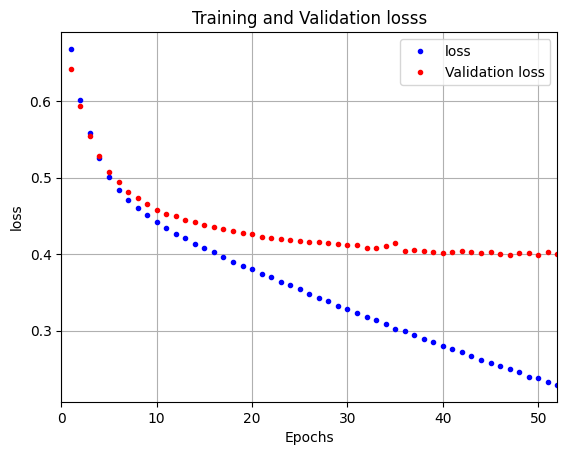

In [ ]:
plot_training_history(baseline_history, monitor='loss')

 ## Scaling up: developing a model that overfits

In [ ]:
overfit = Sequential(
    [
        Dense(32, activation="relu", input_shape=(INPUT_DIMENSION,), name="hidden.0"),
        Dense(16, activation="relu", name="hidden.1"),
        Dense(OUTPUT_DIMENSION, activation="sigmoid", name="output")
    ],
    name="overfit"
)

overfit.summary()

Model: "overfit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden.0 (Dense)            (None, 32)                1984      
                                                                 
 hidden.1 (Dense)            (None, 16)                528       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 2529 (9.88 KB)
Trainable params: 2529 (9.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
learning_rate = 0.001

overfit.compile(optimizer=RMSprop(learning_rate=learning_rate),
                loss=LOSS_FUNC, metrics=METRICS)

In [ ]:
EPOCHS = 100

overfit_history = overfit.fit(Xs_train, ys_train,
                              batch_size=batch_size, epochs=EPOCHS,
                              validation_data=(Xs_val, ys_val),
                              callbacks=[],
                              verbose=0)

In [ ]:
overfit_scores = overfit.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline = {:.2f})'.format(overfit_scores[0], naive_baseline))

Accuracy (Validation): 0.64 (Naive Baseline = 0.70)


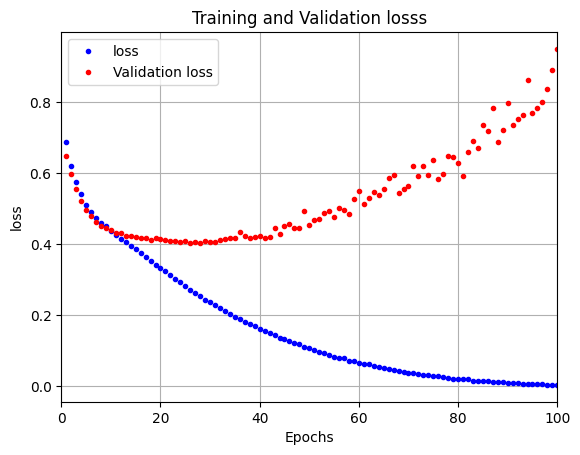

In [ ]:
plot_training_history(overfit_history, monitor='loss')